# <center>Recurrent Neural Network Model to Predict Populations Size

We construct a Many-to-Many recurrent neural network model that takes a sequence of inputs (dosage and initial sizes of the three populations) and provides a corresponding sequence of outputs (predictions for the sizes of the three populations under the given dosage). This specific neural network architecture is chosen due to its compatibility with time series data.

At the end, we just give the model a full treatment and just the initial size, and it will generate the upcoming sizes by inputting the predictions of previous timesteps, so, in the end, we need initial size and full treatment and it will predict all the populations sizes during the treatment.

---
## <center>Defined Libraries 

In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import itertools
import random

---
## <center> Generates the Treatment and Define the Parameters

Define treatments matrix where each array represents a distinct treatment and each value in the array represents dose amount treatment which is given on seven sessions every two days a dose is given, we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population.

In [12]:
Treatment = [[0, 0, 0, 0, 0, 0, 0],
             [1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9, 1e-9],
             [1e-7, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7],
             [1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5],
             [1e-9, 1e-5, 1e-9, 1e-5, 1e-9, 1e-5, 1e-9],
             [0, 1e-5, 0, 1e-5, 0, 1e-5, 0]]
# we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population
observations_horizon = 24  # n number of observations for each value of single treatment
treatment_full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment]
x0 = [60.4551985, 56.1345208, 46.32307756] # initial population  i, x1, x2
t = np.linspace(1, len(treatment_full[0]), len(treatment_full[0]))  # time array
num_plots = len(Treatment) # Set the number of plots to be generated
num_cols = 2  # Set the number of columns for subplots (can be adjusted as needed)
num_rows = int(np.ceil(num_plots / num_cols))

---
## <center> Generate the Data of Lotka-Volterra Model

We generate synthetic data using the dynamical model: Lotka-Voltera with specific parameters

In [13]:
def discrete_lotka_volterra(x0, treatment, params):
    r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3 = params # Parameters of the model
    i0, x10, x20 = x0 #initial values
    i1p, x1p, x2p = [], [], []
    for i in treatment:  # create data based on each treatment
        i_curr, x1_curr, x2_curr = i0, x10, x20    
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            x = x1_curr + x2_curr + i_curr # total population
            f1 = i_curr / x  # frequency of immune cells
            f2 = x1_curr / x # frequency of cancer cells of type 1
            f3 = x2_curr / x # frequency of cancer cells of type 2
            di11 = i_curr * (r1 * f1 + d12 * f2 + d13 * f3) * (1 - x/K) - (c1 + c1 *1e5* i[k]) * i_curr - (m12 + m13) * i_curr
            dx11 = x1_curr * (d21 * f1 + r2 * f2 + d23 * f3) * (1 - x/K) - (c2 + c2  *1e5* i[k]) * x1_curr - m2 * x1_curr + m12 * i_curr + m3 * x2_curr
            dx22 = x2_curr * (d31 * f1 + d32 * f2 + r3 * f3) * (1 - x/K) - (c3 + c3  *1e5* i[k]) * x2_curr - m3 * x2_curr + m13 * i_curr + m2 * x1_curr
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

In [14]:
param_lotka_volterra = [0.3, 0.4, 0.2, 0, 0, 0, 0,0, 0, 300, 0.04, 0.05, 0.05, 0.005, 0.005, 0.01, 0.01]
# r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3 are the parameters
i, x1, x2 = np.array(discrete_lotka_volterra(x0, treatment_full, param_lotka_volterra))

---
## <center>Creating Dataframe for each Treatment Vector

In [15]:
def data_treatment(I): 
    df = pd.DataFrame({'Dose': treatment_full[I], 'I': i[I], 'x1':x1[I], 'x2': x2[I]})
    df_input = df.iloc[:-1,:].reset_index(drop=True)
    df_output = df.iloc[1:,1:].reset_index(drop=True)
    df_output.rename(columns = {'I':'I_next', 'x1':'x1_next', 'x2':'x2_next'}, inplace = True)
    data = pd.concat([df_input, df_output], axis = 1)
    return (data)

frames = [data_treatment(_) for _ in range(len(Treatment))]
Data = pd.concat(frames)
Data.tail()

,Dose,I,x1,x2,I_next,x1_next,x2_next
162,0.0,0.004412,219.826149,32.039206,0.004191,219.269299,32.445909
163,0.0,0.004191,219.269299,32.445909,0.003982,218.733239,32.826480
164,0.0,0.003982,218.733239,32.826480,0.003783,218.220157,33.182562
165,0.0,0.003783,218.220157,33.182562,0.003594,217.731210,33.515712
166,0.0,0.003594,217.731210,33.515712,0.003414,217.266824,33.827400


---
## <center> Build the RNNs

### Define a Class for Attention Layer

In [16]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="uniform", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W))
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

### Define the K-Fold (Cross Validation)

In [17]:
n_splits = 5  # Define the number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits) # Initialize TimeSeriesSplit

### Define the Input and Output Features

In [18]:
val_losses = [] # Lists to store evaluation metrics

input_features = Data[['Dose', 'I', 'x1', 'x2']].values
output_features = Data[['I_next', 'x1_next', 'x2_next']].values

# Normalize input and output features
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
input_features_normalized = input_scaler.fit_transform(input_features)
output_features_normalized = output_scaler.fit_transform(output_features)

### Train the Model

In [19]:
np.random.seed(42) # Set seed for reproducibility
for train_idx, val_idx in tscv.split(input_features_normalized):
    x_train, x_val = input_features_normalized[train_idx], input_features_normalized[val_idx]
    y_train, y_val = output_features_normalized[train_idx], output_features_normalized[val_idx]

    # Reshape the input data for RNN (batch_size, sequence_length, input_dim)
    x_train_reshaped = x_train.reshape(-1, 1, 4)
    x_val_reshaped = x_val.reshape(-1, 1, 4)

    # Define and compile the model (outside the loop)
    model = Sequential()
    model.add(LSTM(120, return_sequences=True, input_shape=(1, 4)))
    # now we add an attention layer to the model and add suitable arguments 
    model.add(AttentionLayer())  # Add the custom Attention layer
    model.add(Dropout(0.2))
    model.add(Dense(120, activation='softplus'))
    model.add(Dense(3))
    optimizer = SGD(learning_rate=0.01, momentum=0.8)
    model.compile(optimizer=optimizer , loss='mean_squared_error')

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Fit the model to the training data
    history = model.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val), epochs=500, batch_size=10, callbacks=[early_stopping])

    # Evaluate the model on the validation set
    val_loss = model.evaluate(x_val_reshaped, y_val)
    val_losses.append(val_loss) 

# Calculate the average validation loss across all splits
average_val_loss = sum(val_losses) / n_splits
print("Average validation loss:", average_val_loss)

Epoch 1/500
17/17 [==============================] - 3s 35ms/step - loss: 0.2847 - val_loss: 0.0821
Epoch 2/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0782 - val_loss: 0.0826
Epoch 3/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0829 - val_loss: 0.0848
Epoch 4/500
17/17 [==============================] - 0s 7ms/step - loss: 0.0760 - val_loss: 0.0736
Epoch 5/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0735 - val_loss: 0.0771
Epoch 6/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0798 - val_loss: 0.0680
Epoch 7/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0753 - val_loss: 0.0708
Epoch 8/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0686 - val_loss: 0.0662
Epoch 9/500
17/17 [==============================] - 0s 6ms/step - loss: 0.0682 - val_loss: 0.0722
Epoch 10/500
17/17 [==============================] - 0s 8ms/step - loss: 0.0691 - val_loss: 0.0656
Epoch 11

### Predict the Output for new Input on Test Treatment
Here we produce new treatment to predict the size of the three populations

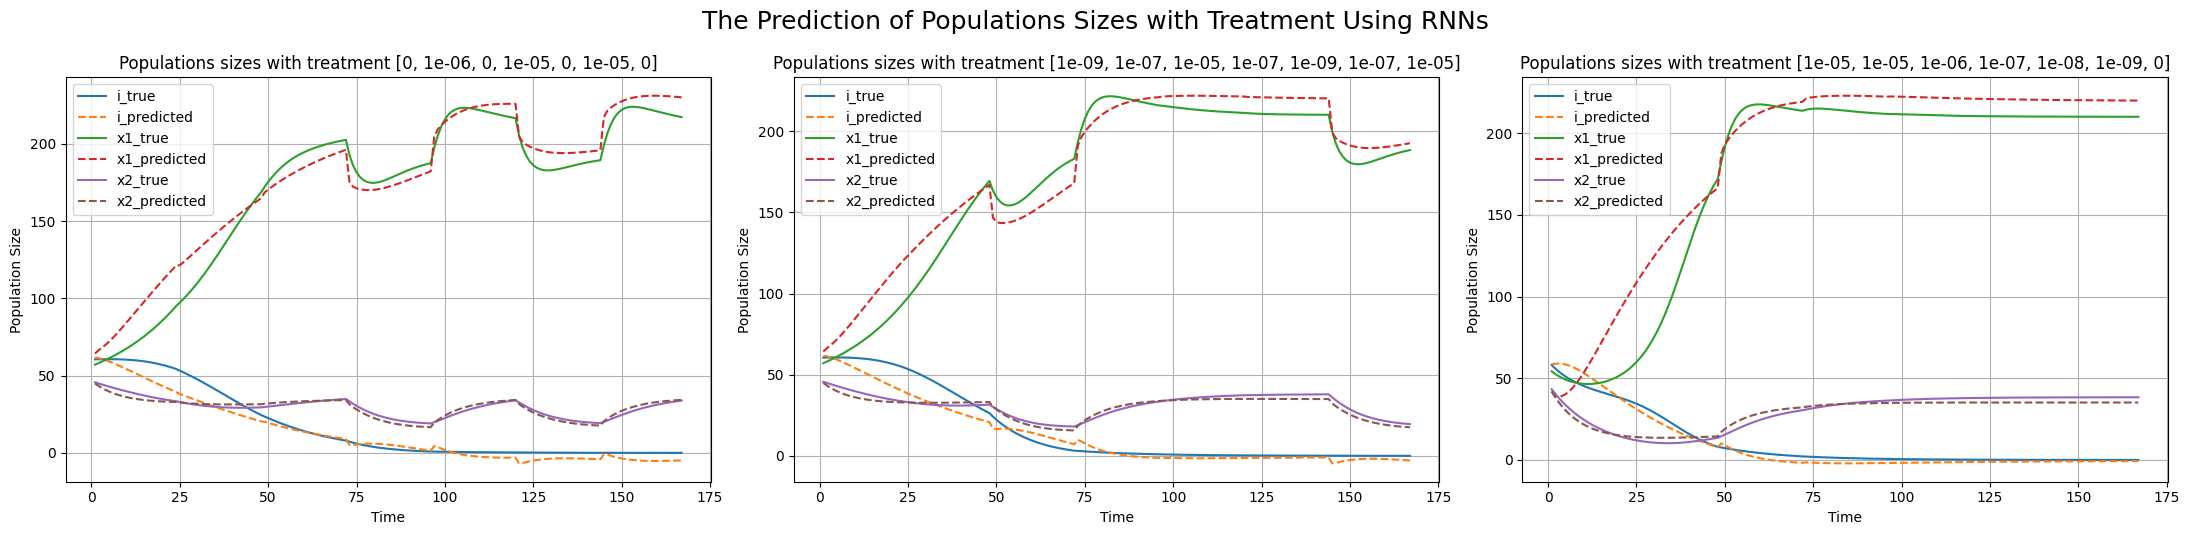

In [22]:
Treatment_test = [[0, 1e-6, 0, 1e-5, 0, 1e-5, 0],
                [1e-9, 1e-7, 1e-5, 1e-7, 1e-9, 1e-7, 1e-5],
                [1e-5, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 0]]
observations_horizon = 24  # n number of observations for each value of single treatment
treatment_full_test = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment_test]
x0 = [60.4551985, 56.1345208, 46.32307756]
i, x1, x2 = np.array(discrete_lotka_volterra(x0, treatment_full_test, param_lotka_volterra))

fig, axs = plt.subplots(1, 3, figsize=(22, 5))  # Adjust the figsize as needed

for I in range(len(treatment_full_test)):
    i_predicted = []
    x1_predicted = []
    x2_predicted = []
    input_0 = np.array([i[I][0], x1[I][0], x2[I][0]])
    for _ in range(len(treatment_full_test[I]) - 1):
        input = np.concatenate((np.array([treatment_full_test[I][_]]), input_0), axis=0).reshape(1, -1)
        new_input_normalized = input_scaler.transform(input)
        new_input_reshaped = new_input_normalized.reshape(1, 1, 4)
        predicted_output_normalized = model.predict(new_input_reshaped, verbose=0)
        predicted_output = output_scaler.inverse_transform(predicted_output_normalized)
        i_predicted.append(predicted_output[0][0]), x1_predicted.append(predicted_output[0][1]), x2_predicted.append(predicted_output[0][2])
        input_0 = np.array([predicted_output[0][0], predicted_output[0][1], predicted_output[0][2]])

    
    # Define true output from the lotka-volterra
    i_true = i[I][1:]
    x1_true = x1[I][1:]
    x2_true = x2[I][1:]

    t= np.linspace(1, 167, 167)
    ax = axs[I]

    # Plot the results for the current I value using the specified axes
    ax.plot(t, i_true, '-', label='i_true')
    ax.plot(t, i_predicted, '--', label='i_predicted')
    ax.plot(t, x1_true, '-', label='x1_true')
    ax.plot(t, x1_predicted, '--', label='x1_predicted')
    ax.plot(t, x2_true, '-', label='x2_true')
    ax.plot(t, x2_predicted, '--', label='x2_predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population Size')
    ax.set_title(f'Populations sizes with treatment {Treatment_test[I]}')
    ax.grid()
    ax.legend()

# Adjust the layout and show the plot
plt.tight_layout()
fig.suptitle('The Prediction of Populations Sizes with Treatment Using RNNs', fontsize=18, y=1.06)
plt.show()